In [25]:
import numpy as np
import matplotlib.pyplot as plt
from utility.utility import short_list, elements_containing_string, contains_substring, slice_string_at_char, get_metadata_item
from utility.algorithm import peak_detect

In [26]:
dtype = np.dtype('float32')
path = "../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_mask.dat"
#path = "../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44.dat"
with open( path, 'rb') as f:
    pulsar_data = np.fromfile(f, dtype)

mean subtraction (doesn't work yet)

In [27]:
#mean_calculator_interval = 2000
#for i in np.arange(0, len(pulsar_data) - mean_calculator_interval, mean_calculator_interval):
#    final_list= []
#    mean_crop = np.median(pulsar_data[i:i+mean_calculator_interval])
#    zeros1, mean_numbers, zeros2= np.zeros([i]), np.full(mean_calculator_interval, mean_crop), np.zeros([int(len(pulsar_data) - i - mean_calculator_interval)])
#    for zero in zeros1:
#        final_list.append(zero)
#    for mean in mean_numbers:
#        final_list.append(mean)
#    for zero in zeros2:
#        final_list.append(zero)
#    array = np.array(final_list)
#    pulsar_data -= array
    

In [28]:
dt = 0.00262143998406827
nbins = 69120 
total_time = nbins * dt
time = [t*dt for t in np.arange(0, nbins)]

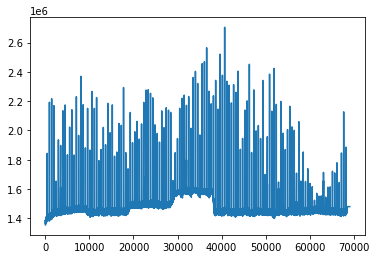

In [29]:
plt.plot(pulsar_data)

In [30]:
metadata_path = '../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_Mask.inf'
#metadata_path = '../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44.inf'
with open(metadata_path) as f:
    metadata = f.readlines()

short_list(metadata)

' Data file name without suffix          =  L197621_SAP0_BEAM1_DM12.44_Mask\n,\t Telescope used                         =  LOFAR\n,\t...\t,\n,\t\n'

In [31]:
nbins = int(get_metadata_item(metadata, 'Number of bins in the time series'))
dt = float(get_metadata_item(metadata, 'Width of each time series bin (sec)'))

(0.0, 209.80255598842447)

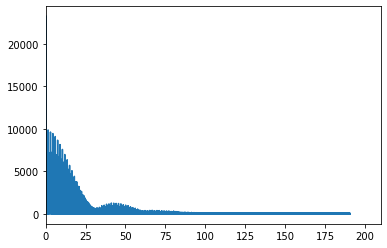

In [32]:
frequencies  = np.fft.fftfreq(nbins, dt)
transform = np.fft.fft(pulsar_data) / len(pulsar_data) # normalize the transform.
plt.clf()
plt.plot(frequencies[1:], abs(transform[1:]))
plt.xlim(0) # to remove the symmetry from the plot.

## Calculation using built-in fftfreq of numpy. 

In [33]:
from scipy.signal import find_peaks
height_threshold = 4700 # Just reading off an apprpriate value from the graph
peaks_index, properties = find_peaks(np.abs(transform), height=height_threshold)

In [34]:
peak_frequencies = [frequencies[i] for i in peaks_index]

(0.0, 25.0)

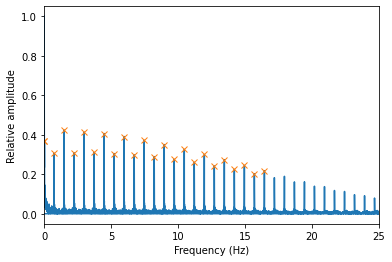

In [35]:
# Just change the height threshold above if we want less peaks to be marked.
plt.clf()
plt.plot(frequencies[1:], np.abs(transform[1:]) / (a := max( np.abs(transform[1:])) ) ,'-', frequencies[peaks_index],properties['peak_heights'] / a,'x')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Relative amplitude")
plt.xlim(0,25)

# automated period finding of pulsar

In [36]:
def find_period(peaks_index, frequencies):
    counter = -1
    list_frequencies_harmonics = []
    for index in peaks_index:
        counter += 1
        if counter ==0:
            freq = frequencies[index]
        else:
            freq = frequencies[index]/counter
        list_frequencies_harmonics.append(freq)
    index = 0
    list_frequencies_harmonics = np.array(list(filter(lambda x: x>0, list_frequencies_harmonics)))
    final_freq = np.mean(list_frequencies_harmonics[1:])
    length = len(list_frequencies_harmonics)
    period = final_freq ** -1
    return period, list_frequencies_harmonics, final_freq

## stacking

In [37]:
period, list_frequencies_harmonics, final_freq = find_period(peaks_index=peaks_index, frequencies=frequencies)
print( period )
print( final_freq )

1.3377139183200188
0.7475439900153389


In [38]:
period_in_index = int(round(period // dt)) # TODO: Can we get this int thing away?? i cannot because it needs to be used as index for list
stack_dict = dict()
i = 0
while i <= nbins:
    stack_dict[f"stack{i // period_in_index}"] = np.array( pulsar_data[i:i+period_in_index])
    i += period_in_index

In [39]:
std = np.std(list_frequencies_harmonics[1:])

def err_period(freq, std_freq):
    error = (std_freq)/(freq**2)
    return error

error_period = err_period(final_freq, std)
print(error_period)
print(std)
print(final_freq)

0.0010500471847445113
0.0005867894857325556
0.7475439900153389


In [40]:
stack = np.zeros(period_in_index) # initializing with zeroes to get the correct stack size.
for key, val in stack_dict.items():
    if ( length := len(val) ) != period_in_index: # This should only happen happen at the end.
        continue
    else:
        stack += val
len(stack) == period_in_index

True

In [41]:
time = [ dt * t for t in range(len(stack))]

Text(0, 0.5, 'Relative amplitude')

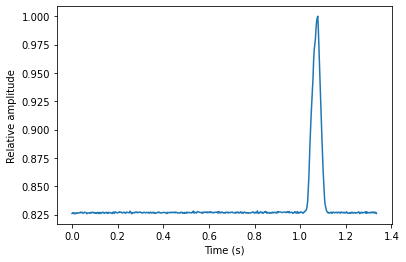

In [42]:
plt.plot(time, stack / max( stack ) )#, color='magenta')
plt.xlabel('Time (s)')
plt.ylabel('Relative amplitude')
#plt.title('graph of an addition of signals of the first radio pulsar ever found.')

Let us find the the period of the pulsar using the stack, which corresponds to the period of the pulsar.

In [43]:
def get_period(time, amplitudes):
    return  time[list(amplitudes).index(max(amplitudes))]
period = get_period(time, stack)
period

1.077411833452059

<Figure size 432x288 with 0 Axes>

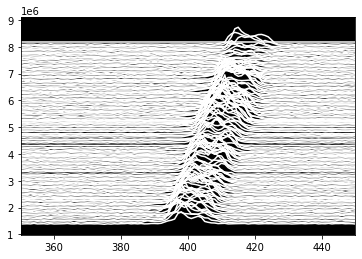

<Figure size 432x288 with 0 Axes>

In [53]:
plt.figure()
#plt.rcParams['axes.facecolor']='white' NOTE: Why does disabling this kill the plot?
# NOTE: As a final version of this plot,
# if we want the pulses to be less overlapping we could simply skip indices of i.
for i, val in enumerate ( stack_dict.values() ) :
    offset = i * 0.05 * 10 **6
    plt.plot(stack_dict[f'stack{i}'] + offset, color='white') 
    plt.xlim(350,450)
plt.figure()

<Figure size 432x288 with 0 Axes>

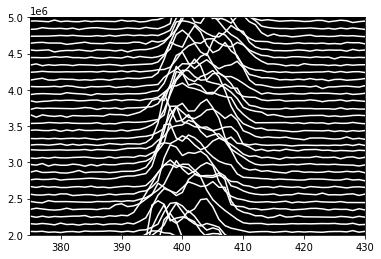

<Figure size 432x288 with 0 Axes>

In [70]:
plt.rcParams['axes.facecolor']='black' #NOTE: Why does disabling this kill the plot?
# NOTE: As a final version of this plot,
# if we want the pulses to be less overlapping we could simply skip indices of i.
for i, val in enumerate ( stack_dict.values() ) :
    offset = i * 0.1 * 10 **6
    plt.plot(stack_dict[f'stack{i}'] + offset, color='white') 
    plt.xlim(375,430)
    plt.ylim(2 * 10 **6, 5 * 10 **6)
plt.figure()